In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import glob
import sys
import os
import re

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, X_train, y_train, Xval=None, yval=None, 
                  opt='rmsprop', batch_size=60, nepochs=50000, patience=500, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2
        
    if Xval is not None:
        val_data = (Xval, yval)
    else:
        val_data = None

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=batch_size, epochs=tr_epochs, verbose=vv, 
                      validation_data=val_data, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


In [4]:
data_dir = '../../datasets/'

def clean_text(text):
    txt = re.sub('\n\n+', '\07', text)
    txt = re.sub('\n', ' ', txt)
    txt = re.sub('\07', '\n', txt)
    txt = re.sub('  +', ' ', txt)
    txt = re.sub('\nCAPÍTULO [^\n]*\n', '\n', txt)    
    return txt.lower()

book_texts = []
book_titles = []
char_count = 0
for fn in glob.glob(data_dir + 'livros/Machado_de_Assis__*.txt'):
    _, book = os.path.basename(fn).split('__')
    txt = open(fn, encoding='utf-8').read()
    txt = clean_text(txt)
    book_texts.append(txt)
    book_titles.append(book[:-4])
    print('{:7d}  {}'.format(len(txt), book[:-4]))
    char_count += len(txt)
print('{:7d}'.format(char_count))

nb_books = len(book_texts)


 347400  Memorias_Postumas_de_Bras_Cubas
 280008  Memorial_de_Aires
 408432  Esau_e_Jaco
 369465  Dom_Casmurro
 326196  Iaia_Garcia
 440240  Quincas_Borba
 327155  Helena
2498896


In [5]:
all_text = ''
for txt in book_texts:
    all_text += txt
    
chars = sorted(list(set(all_text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

nb_chars = len(chars)

print('\ntotal chars:', nb_chars)
print(chars)



total chars: 82
['\n', ' ', '!', '"', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '¡', 'ª', '°', 'º', 'à', 'á', 'â', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ô', 'õ', 'ú', 'ü']


In [6]:
print(book_texts[1][:400])

memorial de aires
9 de janeiro
ora bem, faz hoje um ano que voltei definitivamente da europa. o que me lembrou esta data foi, estando a beber café, o pregão de um vendedor de vassouras e espanadores: "vai vassouras! vai espanadores!" costumo ouvi-lo outras manhãs, mas desta vez trouxe-me à memória o dia do desembarque, quando cheguei aposentado à minha terra, ao meu catete, à minha língua. era o m


In [7]:
seq_len = 40
step = 3
sentences = []
next_chars = []
indexes = []
for k, text in enumerate(book_texts):
    for i in range(0, len(text) - seq_len - 1, step):
        sentences.append(text[i: i + seq_len])
        next_chars.append(text[i + seq_len])
        indexes.append([k, i])

print('nb sequences:', len(sentences))

nb sequences: 832873


In [8]:
print('Vectorization ...')
nb_samples = len(sentences)

X = np.zeros((nb_samples, seq_len, nb_chars), dtype=np.bool)
y = np.zeros((nb_samples, nb_chars), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
print('X.shape:', X.shape)
print('y.shape:', y.shape)


Vectorization ...
X.shape: (832873, 40, 82)
y.shape: (832873, 82)


In [9]:
model_name = '../../models/machado_1'
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, len(chars))))
model.add(BatchNormalization())
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.summary()

# optimizer = RMSprop(lr=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer)


Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               108032    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 82)                10578     
_________________________________________________________________
activation_1 (Activation)    (None, 82)                0         
Total params: 119,122
Trainable params: 118,866
Non-trainable params: 256
_________________________________________________________________


In [10]:
from sklearn.model_selection import train_test_split

X_tra, X_val, y_tra, y_val = train_test_split(X, y, test_size=0.5)
print(X_tra.shape, y_tra.shape, X_val.shape, y_val.shape)

(416436, 40, 82) (416436, 82) (416437, 40, 82) (416437, 82)


In [12]:

fit_params = {
    'opt':        Adam(),
    'batch_size': 128, 
    'nepochs':    60,
    'patience':   15,
    'ploss':      0.0,
    'reset':      False,
}

N = 300000
Xtra, ytra = X_tra[:N], y_tra[:N]

train_network(model, model_name, Xtra, ytra, **fit_params);

[INFO] loading model...
[INFO] training for 0 epochs...


In [ ]:
model, histo = load_model_and_history(model_name)

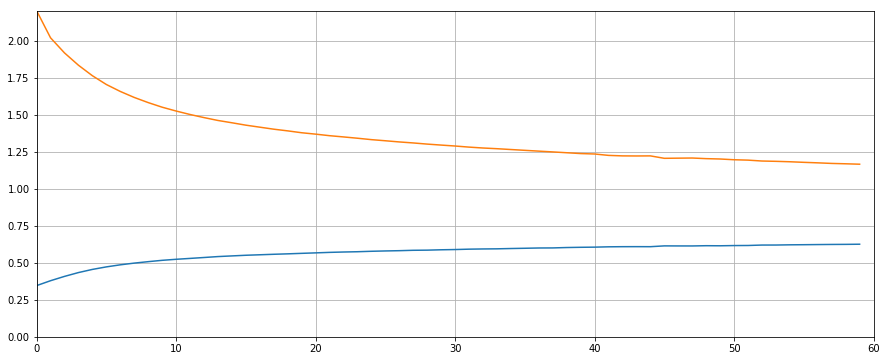

In [37]:
acc = [dd['acc'] for dd in histo.history]
loss = [dd['loss'] for dd in histo.history]
nepochs = len(acc)

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, loss[0])
plot.xlim(0, nepochs)
plot.grid(True)

plot.plot(acc)
plot.plot(loss)


In [13]:
start_index = random.randint(0, len(all_text) - seq_len - 1)
generated = ''
sentence = all_text[start_index: start_index + seq_len]
generated += sentence
print(sentence)
print('-'*len(sentence))

for i in range(400):
    x = np.zeros((1, seq_len, nb_chars))
    for t, char in enumerate(sentence):
        x[0, t, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)[0]
    index = np.argmax(preds)
    next_char = indices_char[index]
    
    generated += next_char
    sentence = sentence[1:] + next_char

    if i%100 == 0:
        print(generated)
        print('-'*60)
    

 e ia a sair do bonde, chegou-se a ele a
----------------------------------------
 e ia a sair do bonde, chegou-se a ele ao
------------------------------------------------------------
 e ia a sair do bonde, chegou-se a ele ao para o meu passo a pergunta.
-- a mim que não disse que não?
 tinha ele, que não fosse a mesma coi
------------------------------------------------------------
 e ia a sair do bonde, chegou-se a ele ao para o meu passo a pergunta.
-- a mim que não disse que não?
 tinha ele, que não fosse a mesma coisa. visse ele estava alguma coisa que estava ao para a conversação. a minha idéia do meu pai em casa
------------------------------------------------------------
 e ia a sair do bonde, chegou-se a ele ao para o meu passo a pergunta.
-- a mim que não disse que não?
 tinha ele, que não fosse a mesma coisa. visse ele estava alguma coisa que estava ao para a conversação. a minha idéia do meu pai em casa de algum dia ao contrário.
 não é podia ser?
da vida do contrato d